
### **Loan Dataset Columns**
#### **Loan Information**
- **loan_amnt**: Số tiền của khoản vay
- **term**: Thời hạn của khoản vay (36 hoặc 60 tháng)
- **int_rate**: Lãi suất của khoản vay
- **installment**:  Số tiền trả hàng tháng của khoản vay

#### **Borrower Information**
- **grade**: Hạng được gán bởi LendingClub dựa trên khả năng tín dụng của người vay
- **sub_grade**: Một hạng chi tiết hơn dựa trên khả năng tín dụng của người vay
- **emp_length**:  Thời gian làm việc của người vay
- **home_ownership**: Loại sở hữu nhà của người vay
- **annual_inc**: Thu nhập hàng năm của người vay
- **verification_status**: Cho biết liệu thu nhập đã được xác minh bởi LendingClub hay không
#### **Loan Details**
- **purpose**: Mục đích của khoản vay
- **dti**: Tỷ lệ nợ trên thu nhập của người vay
- **delinq_2yrs**: Số lần trả nợ chậm trong 2 năm gần đây
- **inq_last_6mths**: Số lần kiểm tra thông tin trong 6 tháng gần đây
- **open_acc**:  Số dòng tín dụng mở trong tệp tín dụng của người vay
- **pub_rec**: Số bản ghi công cộng xấu
- **revol_bal**: Tổng số dư tín dụng quay vòng
- **revol_util**: Số tiền tín dụng mà người vay đang sử dụng so với tổng hạn mức tín dụng của họ
- **total_acc**: Tổng số dòng tín dụng trong tệp tín dụng của người vay
- **last_pymnt_amnt**: Số tiền trả cuối cùng nhận được

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from IPython.display import Image

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, regexp_extract
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
#from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import  RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.types import FloatType, IntegerType
from pyspark.sql.functions import lit
from pyspark.sql import DataFrame

from imblearn.over_sampling import SMOTE

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split


# Functions

In [2]:
def one_hot_encode_column(df, input_col):
    indexer = StringIndexer(inputCol=input_col, outputCol=input_col + '_indexed')
    indexed_df = indexer.fit(df).transform(df)

    encoder = OneHotEncoder(inputCol=input_col + '_indexed', outputCol=input_col + '_encoded')
    encoded_df = encoder.fit(indexed_df).transform(indexed_df)

    encoded_df = encoded_df.drop(input_col, input_col + '_indexed')

    return encoded_df

In [3]:
def scale_features(input_df: DataFrame, input_col: str, output_col: str) -> DataFrame:
    
    scaler = MinMaxScaler(inputCol=input_col, outputCol=output_col)
    scaler_model = scaler.fit(input_df)
    scaled_df = scaler_model.transform(input_df)
    return scaled_df

In [4]:
def evaluate_model(model, model_name, train_data, validation_data, test_data):
    # Fit model trên dữ liệu huấn luyện
    fitted_model = model.fit(train_data)

    # Đánh giá trên dữ liệu huấn luyện
    predictions_train = fitted_model.transform(train_data)
    evaluator_roc = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
    evaluator_pr = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="rawPrediction", metricName="areaUnderPR")
    roc_train = evaluator_roc.evaluate(predictions_train)
    pr_train = evaluator_pr.evaluate(predictions_train)

    # Đánh giá trên dữ liệu validation
    predictions_validation = fitted_model.transform(validation_data)
    roc_validation = evaluator_roc.evaluate(predictions_validation)
    pr_validation = evaluator_pr.evaluate(predictions_validation)

    # Đánh giá trên dữ liệu test
    predictions_test = fitted_model.transform(test_data)
    roc_test = evaluator_roc.evaluate(predictions_test)
    pr_test = evaluator_pr.evaluate(predictions_test)

    # Tạo DataFrame Pandas để lưu kết quả
    results_df = pd.DataFrame({
        "Model": [model_name],
        "ROC AUC (Train)": [round(roc_train, 3)],
        "PR AUC (Train)": [round(pr_train, 3)],
        "ROC AUC (Validation)": [round(roc_validation, 3)],
        "PR AUC (Validation)": [round(pr_validation, 3)],
        "ROC AUC (Test)": [round(roc_test, 3)],
        "PR AUC (Test)": [round(pr_test, 3)],
    })

    return results_df


#Upload dataset

In [5]:
spark = SparkSession.builder \
    .appName("lending-club") \
    .getOrCreate()

In [15]:

df = spark.read.csv('datasetlending.csv', header=True)
df.limit(5).toPandas()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_pymnt_amnt,loan_status
0,3600.0,36 months,13.99,123.03,C,C4,10+ years,MORTGAGE,55000.0,Not Verified,...,5.91,0.0,1.0,7.0,0.0,2765.0,29.7,13.0,122.67,Fully Paid
1,24700.0,36 months,11.99,820.28,C,C1,10+ years,MORTGAGE,65000.0,Not Verified,...,16.06,1.0,4.0,22.0,0.0,21470.0,19.2,38.0,926.35,Fully Paid
2,20000.0,60 months,10.78,432.66,B,B4,10+ years,MORTGAGE,63000.0,Not Verified,...,10.78,0.0,0.0,6.0,0.0,7869.0,56.2,18.0,15813.3,Fully Paid
3,35000.0,60 months,14.85,829.9,C,C5,10+ years,MORTGAGE,110000.0,Source Verified,...,17.06,0.0,0.0,13.0,0.0,7802.0,11.6,17.0,829.9,Current
4,10400.0,60 months,22.45,289.91,F,F1,3 years,MORTGAGE,104433.0,Source Verified,...,25.37,1.0,3.0,12.0,0.0,21929.0,64.5,35.0,10128.96,Fully Paid


In [16]:
num_rows = df.count()
print(f"Số lượng hàng trong DataFrame là: {num_rows}")


Số lượng hàng trong DataFrame là: 2260701


In [17]:
df.printSchema()

root
 |-- loan_amnt: string (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- installment: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- inq_last_6mths: string (nullable = true)
 |-- open_acc: string (nullable = true)
 |-- pub_rec: string (nullable = true)
 |-- revol_bal: string (nullable = true)
 |-- revol_util: string (nullable = true)
 |-- total_acc: string (nullable = true)
 |-- last_pymnt_amnt: string (nullable = true)
 |-- loan_status: string (nullable = true)



In [18]:
df.describe().show()

+-------+------------------+----------+------------------+------------------+-------+---------+----------+--------------+------------------+-------------------+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|         loan_amnt|      term|          int_rate|       installment|  grade|sub_grade|emp_length|home_ownership|        annual_inc|verification_status|purpose|               dti|       delinq_2yrs|    inq_last_6mths|          open_acc|           pub_rec|         revol_bal|       revol_util|         total_acc|   last_pymnt_amnt|       loan_status|
+-------+------------------+----------+------------------+------------------+-------+---------+----------+--------------+------------------+-------------------+-------+------------------+------------------+------------------+------------------+------------------+------------------+--

# EDA

## Missing values

In [8]:
null_counts = df.agg(*[count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

+---------+----+--------+-----------+-----+---------+----------+--------------+----------+-------------------+-------+----+-----------+--------------+--------+-------+---------+----------+---------+---------------+-----------+
|loan_amnt|term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|purpose| dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|last_pymnt_amnt|loan_status|
+---------+----+--------+-----------+-----+---------+----------+--------------+----------+-------------------+-------+----+-----------+--------------+--------+-------+---------+----------+---------+---------------+-----------+
|       33|  33|      33|         33|   33|       33|    146940|            33|        37|                 33|     33|1744|         62|            63|      62|     62|       33|      1835|       62|             33|         33|
+---------+----+--------+-----------+-----+---------+----------+--------------+----------+--

In [9]:
df = df.na.drop()

## 'purpose'

In [10]:
df_with_count = df.groupBy('purpose').count()
df_with_count.show()

+------------------+-------+
|           purpose|  count|
+------------------+-------+
|           wedding|   2321|
|       educational|    412|
|             other| 128096|
|    small_business|  23950|
|debt_consolidation|1197692|
|       credit_card| 483813|
|            moving|  14316|
|          vacation|  14216|
|  renewable_energy|   1348|
|             house|  13099|
|               car|  22416|
|    major_purchase|  47235|
|           medical|  24811|
|  home_improvement| 138271|
+------------------+-------+



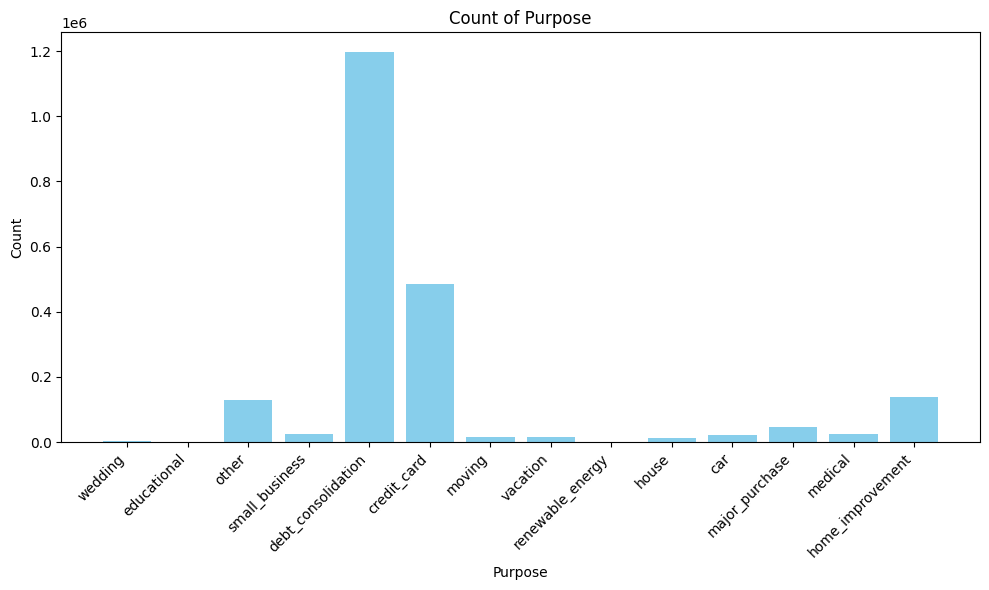

In [58]:
# Chuyển đổi Spark DataFrame sang Pandas DataFrame
pd_df_with_count = df_with_count.toPandas()
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.bar(pd_df_with_count['purpose'], pd_df_with_count['count'], color='skyblue')
plt.xlabel('Purpose')
plt.ylabel('Count')
plt.title('Count of Purpose')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

In [59]:
# Thay thế giá trị trong cột “purposeh” dựa trên điều kiện của cột count
# Nếu 'đếm' nhỏ hơn 300, đặt 'purpose' thành "other", nếu không thì giữ nguyên 'purpose' ban đầu

df = df\
.join(df_with_count, on='purpose', how='left')\
.withColumn("purpose", when(col("count") < 300, "other").otherwise(col("purpose")))\
.drop('count')

In [60]:
unique_purposes = df.select("purpose").distinct()
unique_purposes.show()

+------------------+
|           purpose|
+------------------+
|           wedding|
|       educational|
|             other|
|    small_business|
|debt_consolidation|
|       credit_card|
|            moving|
|          vacation|
|  renewable_energy|
|             house|
|               car|
|    major_purchase|
|           medical|
|  home_improvement|
+------------------+



In [61]:
# Tạo StringIndexer để chuyển cột 'purpose' thành chỉ số số
purpose_indexer = StringIndexer(inputCol="purpose", outputCol="purpose_index", stringOrderType="alphabetAsc")

df = purpose_indexer\
.fit(df)\
.transform(df)\
.drop('purpose')

## 'term'

In [11]:
df_with_count=df.groupby('term').count()
df_with_count.show()

+----------+-------+
|      term|  count|
+----------+-------+
| 36 months|1492070|
| 60 months| 619926|
+----------+-------+



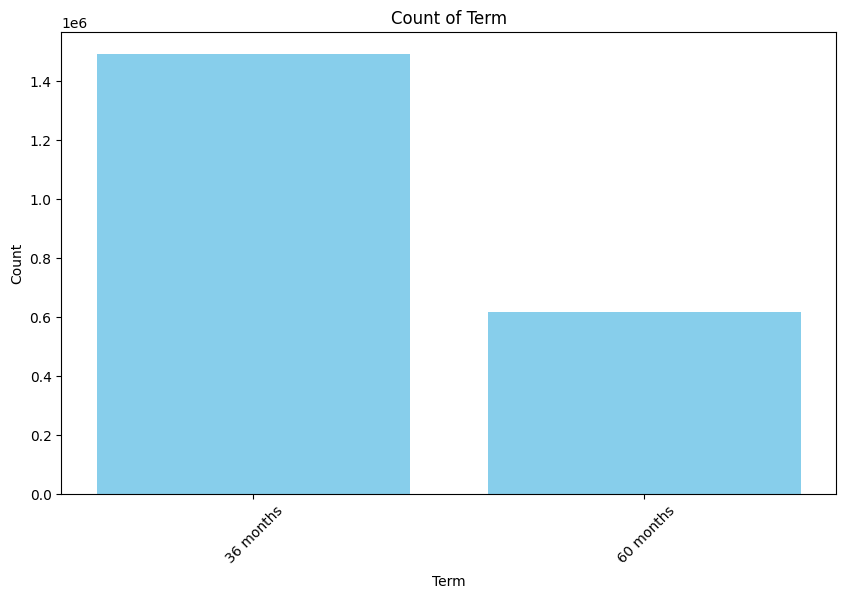

In [12]:
# Chuyển đổi DataFrame PySpark thành DataFrame Pandas
df_with_count_pandas = df_with_count.toPandas()

# Vẽ biểu đồ cột với Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(df_with_count_pandas['term'], df_with_count_pandas['count'], color='skyblue')
plt.xlabel('Term')
plt.ylabel('Count')
plt.title('Count of Term')
plt.xticks(rotation=45)
plt.show()

In [63]:
# Áp dụng biểu thức chính quy để trích xuất các số từ cột 'term' và sau đó chuyển nó sang kiểu dữ liệu Số nguyên.

df = df\
.withColumn("term", regexp_extract(col("term"), r'(\d+)', 0).cast("int"))

## 'verification_status'

In [13]:
df_with_count=df.groupby('verification_status').count()
df_with_count.show()

+-------------------+------+
|verification_status| count|
+-------------------+------+
|           Verified|554142|
|    Source Verified|857902|
|       Not Verified|699952|
+-------------------+------+



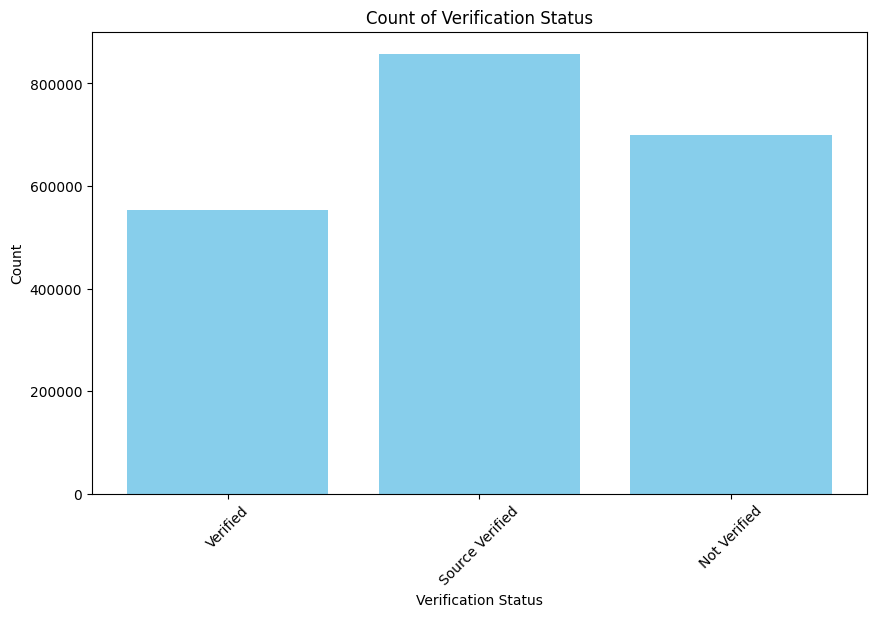

In [14]:
# Chuyển đổi DataFrame PySpark thành DataFrame Pandas
df_with_count_pandas = df_with_count.toPandas()

# Vẽ biểu đồ cột với Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(df_with_count_pandas['verification_status'], df_with_count_pandas['count'], color='skyblue')
plt.xlabel('Verification Status')
plt.ylabel('Count')
plt.title('Count of Verification Status')
plt.xticks(rotation=45)
plt.show()

In [65]:
# Mã hóa các giá trị cột 'verification_status' thành cột mới 'verification_status_encoded'
# Nếu 'verification_status' là "Đã xác minh" hoặc "Đã xác minh nguồn", hãy đặt 'verification_status_encoded' thành 0
# Nếu không thì đặt thành 1

df = df\
.withColumn("verification_status_encoded",
            when(col("verification_status")
                .isin(["Verified", "Source Verified"]),0)
          .otherwise(1))\
.drop("verification_status")

## 'grade'

In [66]:
df_with_count=df.groupby('grade').count()
df_with_count.show()

+-----+------+
|grade| count|
+-----+------+
|    F| 39387|
|    E|126953|
|    B|619969|
|    D|301431|
|    C|607041|
|    A|405725|
|    G| 11490|
+-----+------+



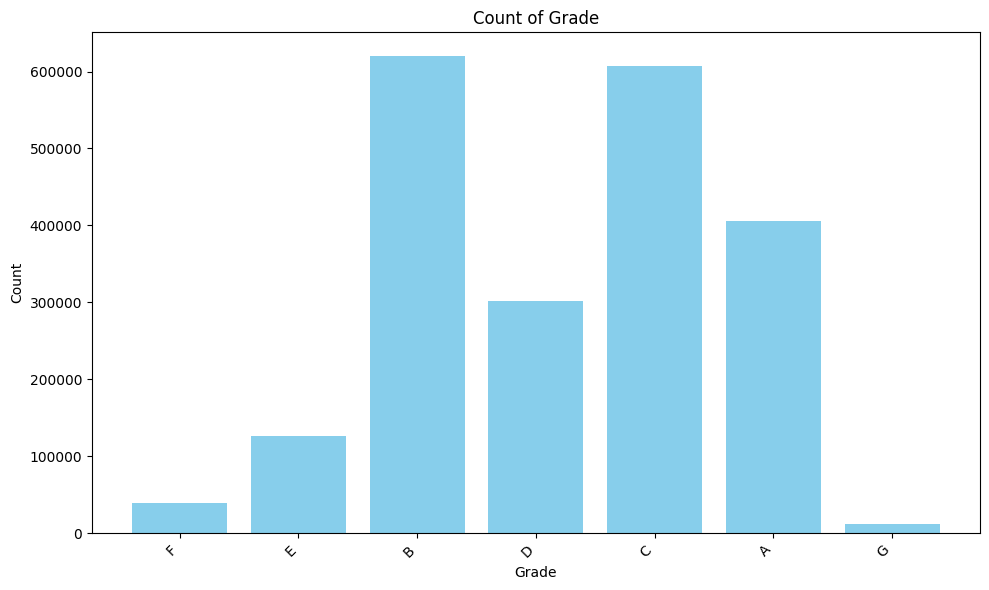

In [67]:
# Chuyển đổi Spark DataFrame sang Pandas DataFrame
pd_df_with_count = df_with_count.toPandas()

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.bar(pd_df_with_count['grade'], pd_df_with_count['count'], color='skyblue')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.title('Count of Grade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

In [68]:

grade_indexer = StringIndexer(inputCol="grade", outputCol="grade_index", stringOrderType="alphabetAsc")

df = grade_indexer\
.fit(df)\
.transform(df)\
.drop('grade')

## 'loan_status' -> target

In [69]:
df.groupby('loan_status').count()\
.show()

+--------------------+-------+
|         loan_status|  count|
+--------------------+-------+
|          Fully Paid|1018715|
|             Default|     35|
|     In Grace Period|   7842|
|         Charged Off| 247260|
|  Late (31-120 days)|  19592|
|             Current| 811980|
|   Late (16-30 days)|   3897|
|Does not meet the...|   1935|
|Does not meet the...|    740|
+--------------------+-------+



In [70]:
# encode 'loan_status' to 0 - fully paid, 1  - charged off
df = df.withColumn("target",
                   when(col("loan_status") == "Fully Paid", 0)
                   .when((col("loan_status") == "Charged Off") , 1)
                   .otherwise(None))\
.drop("loan_status")
df = df.filter(df.target.isNotNull())

In [71]:
df.groupby('target').count()\
.show()

+------+-------+
|target|  count|
+------+-------+
|     1| 247260|
|     0|1018715|
+------+-------+



Emtlength

In [72]:
df_with_count=df.groupby('emp_length').count()
df_with_count.show()

+----------+------+
|emp_length| count|
+----------+------+
|   5 years| 84108|
|   9 years| 50906|
|    1 year| 88425|
|   2 years|121675|
|   7 years| 59583|
|   8 years| 60659|
|   4 years| 80512|
|   6 years| 62691|
|   3 years|107536|
| 10+ years|441927|
|  < 1 year|107953|
+----------+------+



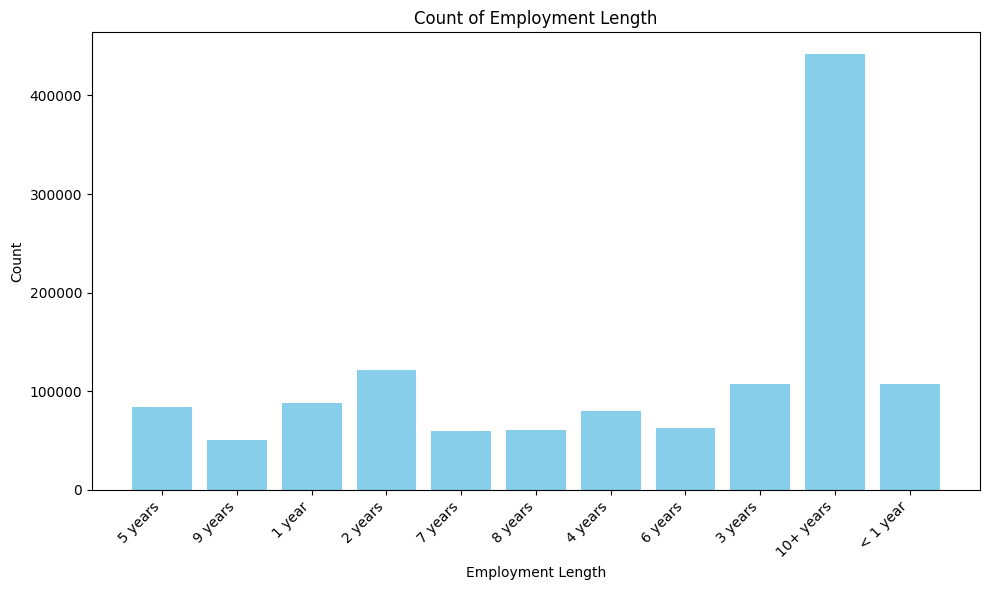

In [73]:
pd_df_with_count = df_with_count.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(pd_df_with_count['emp_length'], pd_df_with_count['count'], color='skyblue')
plt.xlabel('Employment Length')
plt.ylabel('Count')
plt.title('Count of Employment Length')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [74]:

emp_length_indexer = StringIndexer(inputCol="emp_length", outputCol="emp_length_index", stringOrderType="alphabetAsc")

df = emp_length_indexer\
.fit(df)\
.transform(df)\
.drop('emp_length')

In [75]:
df.show()

+---------+----+--------+-----------+---------+--------------+----------+-----+-----------+--------------+--------+-------+---------+----------+---------+---------------+-------------+---------------------------+-----------+------+----------------+
|loan_amnt|term|int_rate|installment|sub_grade|home_ownership|annual_inc|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|last_pymnt_amnt|purpose_index|verification_status_encoded|grade_index|target|emp_length_index|
+---------+----+--------+-----------+---------+--------------+----------+-----+-----------+--------------+--------+-------+---------+----------+---------+---------------+-------------+---------------------------+-----------+------+----------------+
|   5000.0|  36|   13.33|     169.27|       C3|      MORTGAGE|   32000.0| 17.7|        0.0|           0.0|    18.0|    0.0|  11575.0|      76.7|     33.0|        1923.69|         13.0|                          0|        2.0|     0|             1.0|
|  2

home_ownershi

In [76]:
df.groupby('home_ownership').count()\
.show()

+--------------+------+
|home_ownership| count|
+--------------+------+
|           OWN|129082|
|          RENT|507573|
|      MORTGAGE|628869|
|           ANY|   266|
|          NONE|    46|
|         OTHER|   139|
+--------------+------+



In [77]:

home_ownership_indexer = StringIndexer(inputCol="home_ownership", outputCol="home_ownership_index", stringOrderType="alphabetAsc")

df = home_ownership_indexer\
.fit(df)\
.transform(df)\
.drop('home_ownership')

In [78]:
df.show()

+---------+----+--------+-----------+---------+----------+-----+-----------+--------------+--------+-------+---------+----------+---------+---------------+-------------+---------------------------+-----------+------+----------------+--------------------+
|loan_amnt|term|int_rate|installment|sub_grade|annual_inc|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|last_pymnt_amnt|purpose_index|verification_status_encoded|grade_index|target|emp_length_index|home_ownership_index|
+---------+----+--------+-----------+---------+----------+-----+-----------+--------------+--------+-------+---------+----------+---------+---------------+-------------+---------------------------+-----------+------+----------------+--------------------+
|   5000.0|  36|   13.33|     169.27|       C3|   32000.0| 17.7|        0.0|           0.0|    18.0|    0.0|  11575.0|      76.7|     33.0|        1923.69|         13.0|                          0|        2.0|     0|             1.0|  

sub_grade

In [79]:
df.groupby('sub_grade').count()\
.show()

+---------+-----+
|sub_grade|count|
+---------+-----+
|       D5|28007|
|       F2| 6833|
|       B4|78432|
|       A2|35102|
|       E4|14859|
|       B2|69655|
|       C3|70530|
|       D1|47896|
|       C4|69932|
|       F1| 9411|
|       D3|36635|
|       F5| 3745|
|       G2| 2026|
|       B1|67022|
|       B3|77189|
|       E5|13601|
|       C5|63440|
|       G3| 1535|
|       A4|49331|
|       F4| 4614|
+---------+-----+
only showing top 20 rows



In [80]:

sub_grade_indexer = StringIndexer(inputCol="sub_grade", outputCol="sub_grade_index", stringOrderType="alphabetAsc")

df = sub_grade_indexer\
.fit(df)\
.transform(df)\
.drop('sub_grade')

In [81]:
df.show()

+---------+----+--------+-----------+----------+-----+-----------+--------------+--------+-------+---------+----------+---------+---------------+-------------+---------------------------+-----------+------+----------------+--------------------+---------------+
|loan_amnt|term|int_rate|installment|annual_inc|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|last_pymnt_amnt|purpose_index|verification_status_encoded|grade_index|target|emp_length_index|home_ownership_index|sub_grade_index|
+---------+----+--------+-----------+----------+-----+-----------+--------------+--------+-------+---------+----------+---------+---------------+-------------+---------------------------+-----------+------+----------------+--------------------+---------------+
|   5000.0|  36|   13.33|     169.27|   32000.0| 17.7|        0.0|           0.0|    18.0|    0.0|  11575.0|      76.7|     33.0|        1923.69|         13.0|                          0|        2.0|     0|           

In [89]:
columns_to_cast = [ 'loan_amnt',
                   'int_rate',
                    'installment',
                    'annual_inc',
                    'dti',
                    'delinq_2yrs',
                    'open_acc',
                    'pub_rec',
                    'revol_bal',
                    'revol_util',
                    'total_acc',
                    'inq_last_6mths',
                    'last_pymnt_amnt'
]

# chuyen sang float
for column_name in columns_to_cast:
    df = df.withColumn(column_name, col(column_name).cast('float'))

# Downsampling
Bằng cách áp dụng kỹ thuật giảm mẫu trên Lớp 0(undersampling)

In [82]:
df = df.drop('id')

In [90]:
# Áp dụng undersampling trên nhãn 0
fraction = 0.3  # giảm xuống 30% số lượng ban đầu của nhãn 0
df_class_0 = df.filter(col("target") == 0).sample(fraction=fraction, seed=42)
df_class_1 = df.filter(col("target") == 1)

# Kết hợp lại các hàng đã lọc và lấy mẫu
df_downsampled = df_class_0.union(df_class_1)

# Xóa các giá trị thiếu
df_downsampled = df_downsampled.na.drop()

# Kiểm tra phân phối nhãn sau khi undersampling
df_downsampled.groupBy("target").count().show()

+------+------+
|target| count|
+------+------+
|     0|305997|
|     1|247260|
+------+------+



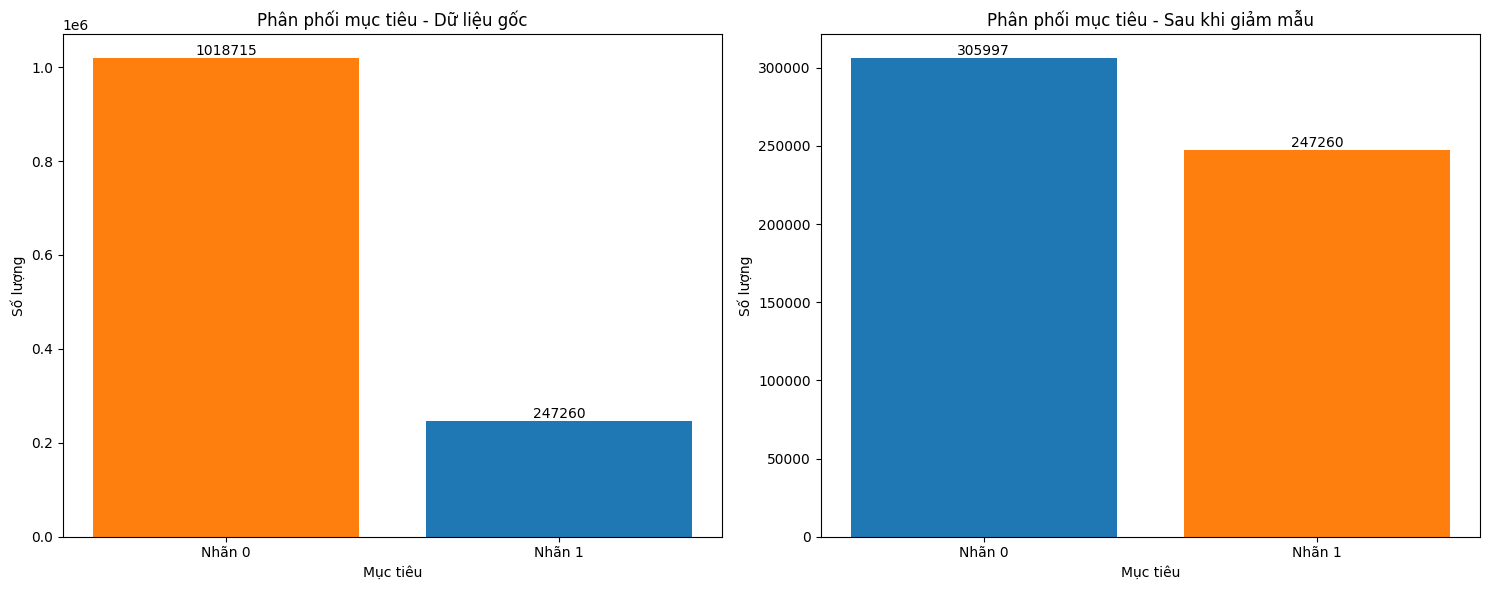

In [84]:
# Chuẩn bị dữ liệu
loan_status_count_original = df.groupby('target').count().toPandas()
loan_status_count_downsampled = df_downsampled.groupby('target').count().toPandas()

# Danh sách các màu cho từng nhãn
colors = ['#1f77b4', '#ff7f0e']

# Tạo figure và subplot
plt.figure(figsize=(15, 6))

# Biểu đồ cột cho dữ liệu gốc
plt.subplot(1, 2, 1)
bars = plt.bar(loan_status_count_original['target'], loan_status_count_original['count'], color=colors)
plt.xlabel('Mục tiêu')
plt.ylabel('Số lượng')
plt.title('Phân phối mục tiêu - Dữ liệu gốc')
plt.xticks([0, 1], ['Nhãn 0', 'Nhãn 1'])

# Thêm số liệu trên mỗi cột
for bar, count in zip(bars, loan_status_count_original['count']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, count, ha='center', va='bottom')

# Biểu đồ cột cho dữ liệu sau khi giảm mẫu
plt.subplot(1, 2, 2)
bars = plt.bar(loan_status_count_downsampled['target'], loan_status_count_downsampled['count'], color=colors)
plt.xlabel('Mục tiêu')
plt.ylabel('Số lượng')
plt.title('Phân phối mục tiêu - Sau khi giảm mẫu')
plt.xticks([0, 1], ['Nhãn 0', 'Nhãn 1'])

# Thêm số liệu trên mỗi cột
for bar, count in zip(bars, loan_status_count_downsampled['count']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, count, ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [91]:
df.groupBy("target").count().show()
count_class_0 = df.filter(col("target") == 0).count()
count_class_1 = df.filter(col("target") == 1).count()
difference = count_class_0 - count_class_1
df_class_1 = df.filter(col("target") == 1)
df_class_1_oversampled = df_class_1.sample(withReplacement=True, fraction=(difference / count_class_1) + 1, seed=42)
df_oversampled = df.filter(col("target") == 0).union(df_class_1_oversampled)
df_oversampled = df_oversampled.na.drop()
df_oversampled.groupBy("target").count().show()


+------+-------+
|target|  count|
+------+-------+
|     1| 247260|
|     0|1018715|
+------+-------+

+------+-------+
|target|  count|
+------+-------+
|     0|1018715|
|     1|1018820|
+------+-------+



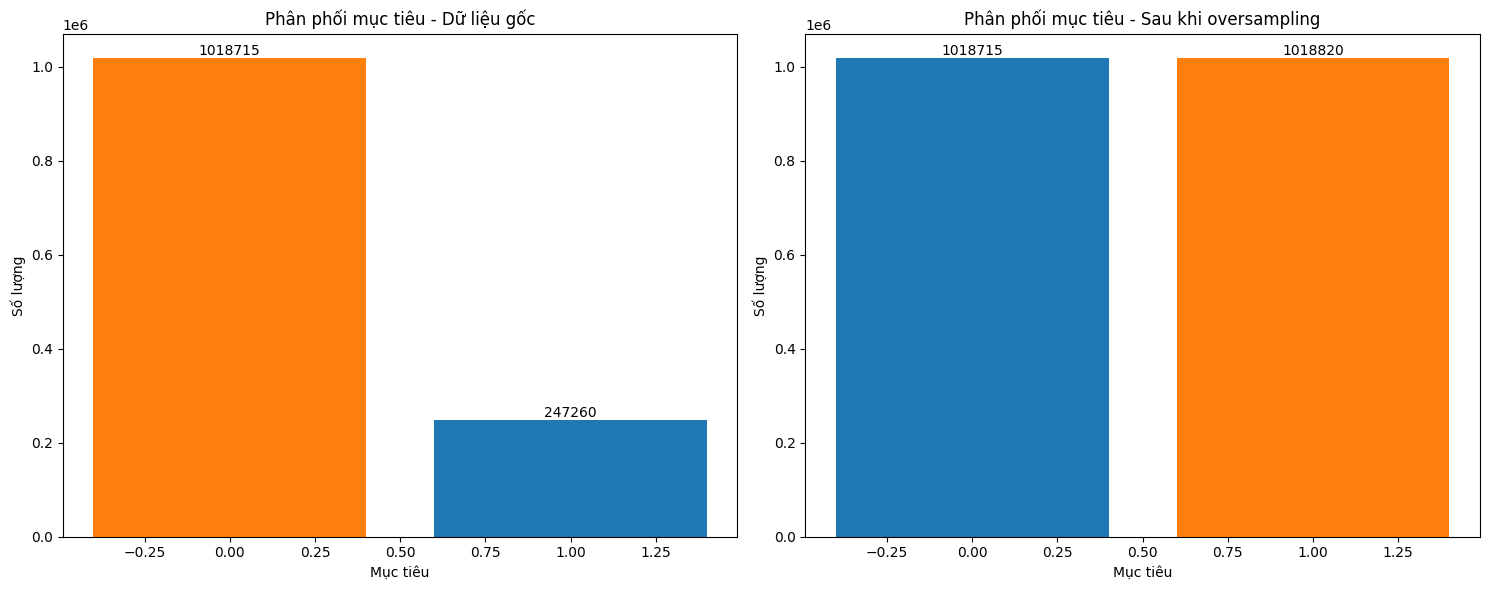

In [86]:
# Chuẩn bị dữ liệu
loan_status_count_original = df.groupby('target').count().toPandas()
loan_status_count_oversampled = df_oversampled.groupby('target').count().toPandas()

# Màu sắc cho từng nhãn
colors = ['#1f77b4', '#ff7f0e']

# Tạo figure và subplot
plt.figure(figsize=(15, 6))

# Biểu đồ cột cho dữ liệu gốc
plt.subplot(1, 2, 1)
bars = plt.bar(loan_status_count_original['target'], loan_status_count_original['count'], color=colors)
plt.xlabel('Mục tiêu')
plt.ylabel('Số lượng')
plt.title('Phân phối mục tiêu - Dữ liệu gốc')

# Thêm số liệu trên mỗi cột
for bar, count in zip(bars, loan_status_count_original['count']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, count, ha='center', va='bottom')

# Biểu đồ cột cho dữ liệu sau khi oversampling
plt.subplot(1, 2, 2)
bars = plt.bar(loan_status_count_oversampled['target'], loan_status_count_oversampled['count'], color=colors)
plt.xlabel('Mục tiêu')
plt.ylabel('Số lượng')
plt.title('Phân phối mục tiêu - Sau khi oversampling')

# Thêm số liệu trên mỗi cột
for bar, count in zip(bars, loan_status_count_oversampled['count']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, count, ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [87]:
df.printSchema()

root
 |-- loan_amnt: string (nullable = true)
 |-- term: integer (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- installment: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- inq_last_6mths: string (nullable = true)
 |-- open_acc: string (nullable = true)
 |-- pub_rec: string (nullable = true)
 |-- revol_bal: string (nullable = true)
 |-- revol_util: string (nullable = true)
 |-- total_acc: string (nullable = true)
 |-- last_pymnt_amnt: string (nullable = true)
 |-- purpose_index: double (nullable = false)
 |-- verification_status_encoded: integer (nullable = false)
 |-- grade_index: double (nullable = false)
 |-- target: integer (nullable = true)
 |-- emp_length_index: double (nullable = false)
 |-- home_ownership_index: double (nullable = false)
 |-- sub_grade_index: double (nullable = false)



In [44]:
columns_to_cast = [ 'loan_amnt',
                   'int_rate',
                    'installment',
                    'annual_inc',
                    'dti',
                    'delinq_2yrs',
                    'open_acc',
                    'pub_rec',
                    'revol_bal',
                    'revol_util',
                    'total_acc',
                    'inq_last_6mths',
                    'last_pymnt_amnt'
]

# cast to float
for column_name in columns_to_cast:
    df = df.withColumn(column_name, col(column_name).cast('float'))

In [92]:
df.printSchema()

root
 |-- loan_amnt: float (nullable = true)
 |-- term: integer (nullable = true)
 |-- int_rate: float (nullable = true)
 |-- installment: float (nullable = true)
 |-- annual_inc: float (nullable = true)
 |-- dti: float (nullable = true)
 |-- delinq_2yrs: float (nullable = true)
 |-- inq_last_6mths: float (nullable = true)
 |-- open_acc: float (nullable = true)
 |-- pub_rec: float (nullable = true)
 |-- revol_bal: float (nullable = true)
 |-- revol_util: float (nullable = true)
 |-- total_acc: float (nullable = true)
 |-- last_pymnt_amnt: float (nullable = true)
 |-- purpose_index: double (nullable = false)
 |-- verification_status_encoded: integer (nullable = false)
 |-- grade_index: double (nullable = false)
 |-- target: integer (nullable = true)
 |-- emp_length_index: double (nullable = false)
 |-- home_ownership_index: double (nullable = false)
 |-- sub_grade_index: double (nullable = false)



# VectorAssembler

downspampled

In [93]:
all_columns = df_downsampled.columns
feature_cols = [col_name for col_name in all_columns if col_name != 'target']

target = ['target']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_to_scale")

df_downsampled = assembler.transform(df_downsampled)

In [94]:
df_downsampled\
.select('features_to_scale', 'target')\
.show(5)

+--------------------+------+
|   features_to_scale|target|
+--------------------+------+
|[3600.0,36.0,13.6...|     0|
|[27500.0,60.0,14....|     0|
|[11000.0,36.0,10....|     0|
|[2000.0,36.0,11.9...|     0|
|[10000.0,36.0,11....|     0|
+--------------------+------+
only showing top 5 rows



oversampled

In [95]:
all_columns = df_oversampled.columns
feature_cols = [col_name for col_name in all_columns if col_name != 'target']

target = ['target']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_to_scale")

df_oversampled = assembler.transform(df_oversampled)

In [96]:
df_oversampled\
.select('features_to_scale', 'target')\
.show(5)

+--------------------+------+
|   features_to_scale|target|
+--------------------+------+
|[5000.0,36.0,13.3...|     0|
|[23100.0,60.0,25....|     0|
|[3600.0,36.0,9.98...|     0|
|[3600.0,36.0,13.6...|     0|
|[3875.0,36.0,25.8...|     0|
+--------------------+------+
only showing top 5 rows



#MinMaxScaler với under

In [97]:
train_data, temp_data = df_downsampled.randomSplit([0.8, 0.2], seed=42)
test_data, val_data = temp_data.randomSplit([0.5, 0.5], seed=42)

In [98]:
train_data = scale_features(train_data, "features_to_scale", "features")
val_data = scale_features(val_data, "features_to_scale", "features")
test_data = scale_features(test_data, "features_to_scale", "features")

In [111]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'target')
rf_model = rf.fit(train_data)
results_df_rf = evaluate_model(rf, 'Random Forest', train_data, val_data, test_data)

In [102]:
from pyspark.ml.classification import DecisionTreeClassifier

In [110]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'target')
dt_model = dt.fit(train_data)
results_df_dt = evaluate_model(dt, 'Decision Tree', train_data, val_data, test_data)

In [109]:
lr = LogisticRegression(featuresCol='features', labelCol='target')
lr_model = lr.fit(train_data)
results_df_lr = evaluate_model(lr, 'LogisticRegression', train_data, val_data, test_data)

In [112]:
final_results_df = pd.concat([results_df_lr, results_df_rf,results_df_dt ], ignore_index=True)
final_results_df

,Model,ROC AUC (Train),PR AUC (Train),ROC AUC (Validation),PR AUC (Validation),ROC AUC (Test),PR AUC (Test)
0,LogisticRegression,0.926,0.880,0.926,0.879,0.925,0.881
1,Random Forest,0.927,0.891,0.930,0.895,0.928,0.892
2,Decision Tree,0.875,0.757,0.880,0.765,0.874,0.755


#Minmaxcaler với Over

In [115]:
train_data, temp_data = df_oversampled.randomSplit([0.8, 0.2], seed=42)
test_data, val_data = temp_data.randomSplit([0.5, 0.5], seed=42)

In [116]:
train_data = scale_features(train_data, "features_to_scale", "features")
val_data = scale_features(val_data, "features_to_scale", "features")
test_data = scale_features(test_data, "features_to_scale", "features")

In [117]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'target')
results_df_rf = evaluate_model(rf, 'Random Forest', train_data, val_data, test_data)

# Models

In [ ]:
# Kiểm tra kiểu và số lượng cột của DataFrame
print("Schema của DataFrame:")
df.printSchema()

# Đếm số lượng cột
num_columns = len(df.columns)
print("Số lượng cột:", num_columns)


Schema của DataFrame:
root
 |-- term: integer (nullable = true)
 |-- acc_now_delinq: integer (nullable = true)
 |-- annual_inc: float (nullable = true)
 |-- application_type: integer (nullable = true)
 |-- dti: float (nullable = true)
 |-- installment: float (nullable = true)
 |-- int_rate: float (nullable = true)
 |-- loan_amnt: float (nullable = true)
 |-- tax_liens: float (nullable = true)
 |-- delinq_amnt: float (nullable = true)
 |-- policy_code: float (nullable = true)
 |-- last_fico_range_high: float (nullable = true)
 |-- last_fico_range_low: float (nullable = true)
 |-- recoveries: float (nullable = true)
 |-- collection_recovery_fee: float (nullable = true)
 |-- verification_status_encoded: integer (nullable = false)
 |-- grade_index: double (nullable = false)
 |-- purpose_encoded: vector (nullable = true)
 |-- addr_state_encoded: vector (nullable = true)
 |-- home_ownership_encoded: vector (nullable = true)
 |-- initial_list_status_encoded: vector (nullable = true)
 |-- targ

## Logistic Regression

In [118]:
lr = LogisticRegression(featuresCol='features', labelCol='target')
results_df_lr = evaluate_model(lr, 'LogisticRegression', train_data, val_data, test_data)

## Random Forest

In [44]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'target')
results_df_rf = evaluate_model(rf, 'Random Forest', train_data, val_data, test_data)

## Decision Tree


In [119]:
from pyspark.ml.classification import DecisionTreeClassifier

In [120]:
dc = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'target')
results_df_dc = evaluate_model(dc, 'Decision Tree', train_data, val_data, test_data)

## Results

In [121]:
final_results_df = pd.concat([results_df_lr, results_df_rf,results_df_dc ], ignore_index=True)
final_results_df

,Model,ROC AUC (Train),PR AUC (Train),ROC AUC (Validation),PR AUC (Validation),ROC AUC (Test),PR AUC (Test)
0,LogisticRegression,0.926,0.900,0.925,0.899,0.923,0.899
1,Random Forest,0.925,0.904,0.924,0.903,0.926,0.905
2,Decision Tree,0.874,0.792,0.874,0.791,0.874,0.794


## Grid Search & Cross Validation

In [126]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [127]:
# Định nghĩa mô hình Random Forest
rf_model = RandomForestClassifier(featuresCol='features', labelCol='target')

# Định nghĩa bộ đánh giá Area Under ROC Curve (AUC)
auc_evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC", labelCol="target")

# Định nghĩa lưới tham số cho Random Forest
paramGrid = ParamGridBuilder() \
    .addGrid(rf_model.numTrees, [10, 50, 100]) \
    .addGrid(rf_model.maxDepth, [5, 10, 15]) \
    .build()

# Khởi tạo CrossValidator
crossval = CrossValidator(estimator=rf_model,
                          estimatorParamMaps=paramGrid,
                          evaluator=auc_evaluator,
                          numFolds=5,
                          parallelism=4)  # Sử dụng xử lý song song nếu có thể

# Huấn luyện mô hình trên dữ liệu huấn luyện
cvModel = crossval.fit(train_data)

# Lấy mô hình tốt nhất từ CrossValidator
best_rf_model = cvModel.bestModel

# Đánh giá mô hình tốt nhất trên tập kiểm tra
predictions = best_rf_model.transform(test_data)
auc_score = auc_evaluator.evaluate(predictions)

print(f'AUC Score trên tập kiểm tra: {auc_score}')

# Đánh giá chi tiết các tham số và metric của từng bộ tham số
estimator_param_maps = cvModel.getEstimatorParamMaps()
avg_metrics = cvModel.avgMetrics

for idx, param_map in enumerate(estimator_param_maps):
    metrics = avg_metrics[idx]
    print("\nParameters:", param_map)
    print("Average Metric (AUC):", metrics)
    print("---")

In [ ]:
# Định nghĩa mô hình Random Forest
rf_model = RandomForestClassifier(featuresCol='features', labelCol='target')

# Lấy mẫu một tập dữ liệu nhỏ hơn từ tập dữ liệu huấn luyện ban đầu

train_data, temp_data = df_oversampled.randomSplit([0.8, 0.2], seed=42)
# Định nghĩa lưới tham số cho Random Forest
paramGrid = ParamGridBuilder() \
    .addGrid(rf_model.numTrees, [10, 50, 100]) \
    .addGrid(rf_model.maxDepth, [5, 10, 15]) \
    .build()

# Định nghĩa bộ đánh giá Area Under ROC Curve (AUC)
auc_evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC", labelCol="target")

# Khởi tạo CrossValidator với tập dữ liệu nhỏ hơn
crossval = CrossValidator(estimator=rf_model,
                          estimatorParamMaps=paramGrid,
                          evaluator=auc_evaluator,
                          numFolds=5,
                          parallelism=4)  # Sử dụng xử lý song song nếu có thể

# Huấn luyện mô hình trên tập dữ liệu nhỏ hơn
cvModel_sample = crossval.fit(train_data_sample)

# Lấy mô hình tốt nhất từ quá trình tinh chỉnh ban đầu
best_rf_model = cvModel_sample.bestModel

# Đánh giá mô hình tốt nhất trên tập kiểm tra
results_df_rf = evaluate_model(best_rf_model, 'Random Forest', train_data, validation_data, test_data)

# In kết quả đánh giá
print(results_df_rf)